In [28]:
# Set up the configuration for accessing the storage account
storage_account_name = "team12storage"
storage_account_key = "ZdpCqxRwuQbJ8fUYN7EMbTLjOyj+I9rI6IjcQ/uU+4aFG46TQqjiz1Piq9SWKGkkjszo3r94l26M+AStR5PvPg=="

spark.conf.set(
    "fs.azure.account.key." + storage_account_name + ".dfs.core.windows.net",
    storage_account_key
)

StatementMeta(StockPool, 3, 29, Finished, Available, Finished)

In [29]:
container = "team12blobcontainer"
abfss_base_path = f"abfss://{container}@{storage_account_name}.dfs.core.windows.net/"
tweet_df = spark.read.parquet(f"{abfss_base_path}Medallion/Silver/Tweet_Monthly_Silver/*")
display(tweet_df.limit(10))

StatementMeta(StockPool, 3, 30, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7d4808e5-6db8-4f19-8e94-bbd91f2426fd)

In [45]:
# Comprehensive Twitter Data Analysis with PySpark
# Import necessary libraries
from pyspark.sql.functions import col, count, avg, min, max, length, lit, to_date, datediff, split, lower, regexp_extract, explode, mean, when, desc, sum as sum_
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

StatementMeta(StockPool, 3, 46, Finished, Available, Finished)

In [33]:
# 1. BASIC DATA UNDERSTANDING
print(f"Total records: {tweet_df.count()}")
print(f"Total columns: {len(tweet_df.columns)}")

StatementMeta(StockPool, 3, 34, Finished, Available, Finished)

Total records: 70127
Total columns: 20


In [34]:
# Display basic information about each column
for column in tweet_df.columns:
    print(f"Column: {column}, Type: {tweet_df.schema[column].dataType}")

StatementMeta(StockPool, 3, 35, Finished, Available, Finished)

Column: user_id, Type: StringType()
Column: is_blue_verified, Type: BooleanType()
Column: account_created_at, Type: DateType()
Column: followers_count, Type: IntegerType()
Column: friends_count, Type: IntegerType()
Column: account_favourites_count, Type: IntegerType()
Column: listed_count, Type: IntegerType()
Column: media_count, Type: IntegerType()
Column: account_possibly_sensitive, Type: BooleanType()
Column: rest_id, Type: StringType()
Column: tweet_created_at_date, Type: DateType()
Column: tweet_created_at_time, Type: StringType()
Column: Is_weekend, Type: BooleanType()
Column: view_count, Type: StringType()
Column: retweet_count, Type: IntegerType()
Column: reply_count, Type: IntegerType()
Column: quote_count, Type: IntegerType()
Column: favorite_count, Type: IntegerType()
Column: tweet_possibly_sensitive, Type: BooleanType()
Column: full_text, Type: StringType()


In [35]:
# Check for null values in each column
null_counts = []
for column in tweet_df.columns:
    null_count = tweet_df.filter(col(column).isNull()).count()
    null_counts.append((column, null_count))

null_df = spark.createDataFrame(null_counts, ["Column", "Null Count"])
display(null_df.orderBy("Null Count", ascending=False))

StatementMeta(StockPool, 3, 36, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ca87b637-07cd-4444-bc29-98175e780a90)

In [36]:
# 2. DATA PREPARATION
# Convert view_count to integer for proper analysis
tweet_df = tweet_df.withColumn("view_count_int", 
                              when(col("view_count").cast(IntegerType()).isNotNull(), 
                                   col("view_count").cast(IntegerType())).otherwise(0))

# Extract hour from time
tweet_df = tweet_df.withColumn("tweet_hour", split(col("tweet_created_at_time"), ":")[0].cast(IntegerType()))

# Calculate account age
tweet_df = tweet_df.withColumn("account_age_days", 
                              datediff(to_date(lit("2024-01-12")), col("account_created_at")))

# Add text length column
tweet_df = tweet_df.withColumn("text_length", length(col("full_text")))

# Create total engagement column
tweet_df = tweet_df.withColumn("total_engagement", 
                              col("retweet_count") + col("favorite_count") + col("reply_count") + col("quote_count"))

StatementMeta(StockPool, 3, 37, Finished, Available, Finished)

In [37]:
# Set plotting style
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")

StatementMeta(StockPool, 3, 38, Finished, Available, Finished)

StatementMeta(StockPool, 3, 39, Finished, Available, Finished)

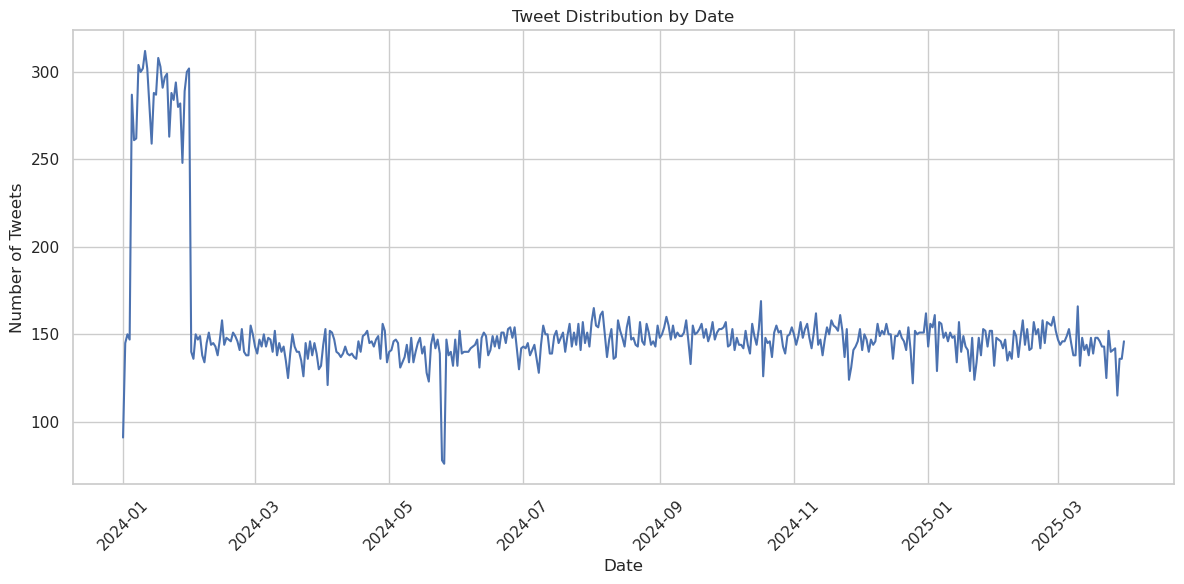

In [38]:
# 3. TEMPORAL ANALYSIS
# Distribution of tweets over time
tweets_by_date = tweet_df.groupBy("tweet_created_at_date").count().orderBy("tweet_created_at_date")
date_counts_pd = tweets_by_date.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(date_counts_pd["tweet_created_at_date"], date_counts_pd["count"])
plt.title("Tweet Distribution by Date")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


StatementMeta(StockPool, 3, 40, Finished, Available, Finished)

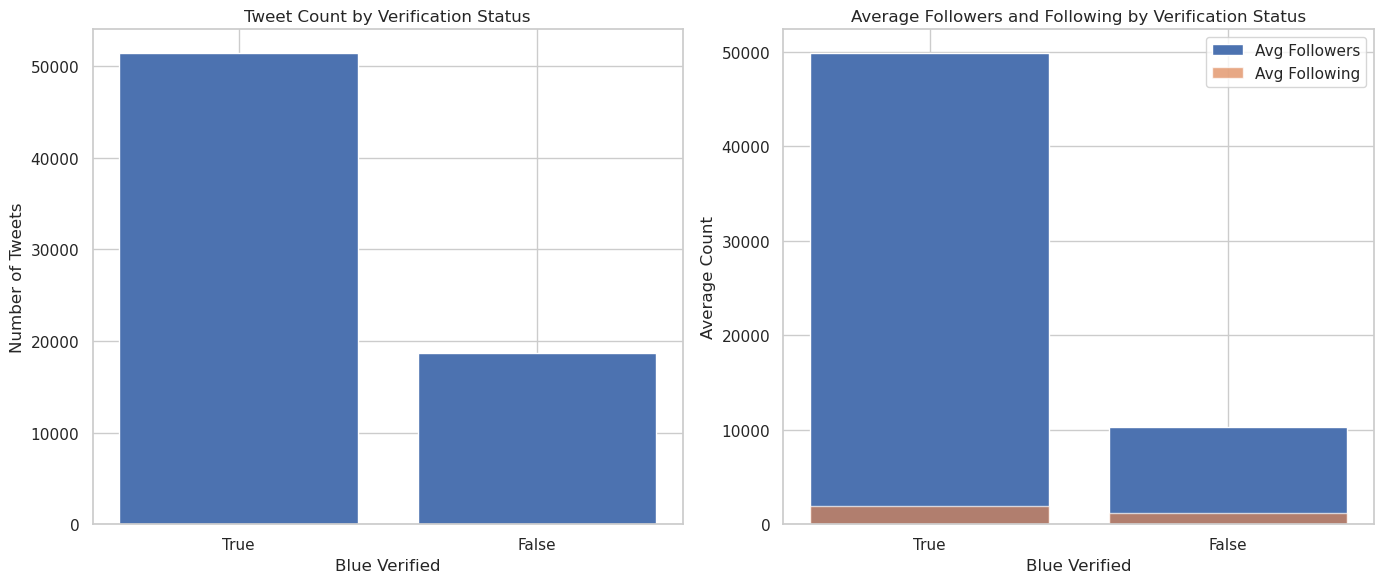

In [39]:
# 4. USER ANALYSIS
# Distribution of users by verification status
blue_verified_stats = tweet_df.groupBy("is_blue_verified").agg(
    count("*").alias("tweet_count"),
    avg("followers_count").alias("avg_followers"),
    avg("friends_count").alias("avg_following")
)
verified_data = blue_verified_stats.toPandas()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].bar(verified_data["is_blue_verified"].astype(str), verified_data["tweet_count"])
ax[0].set_title("Tweet Count by Verification Status")
ax[0].set_xlabel("Blue Verified")
ax[0].set_ylabel("Number of Tweets")

ax[1].bar(verified_data["is_blue_verified"].astype(str), verified_data["avg_followers"], label="Avg Followers")
ax[1].bar(verified_data["is_blue_verified"].astype(str), verified_data["avg_following"], label="Avg Following", alpha=0.7)
ax[1].set_title("Average Followers and Following by Verification Status")
ax[1].set_xlabel("Blue Verified")
ax[1].set_ylabel("Average Count")
ax[1].legend()

plt.tight_layout()
plt.show()

StatementMeta(StockPool, 3, 41, Finished, Available, Finished)

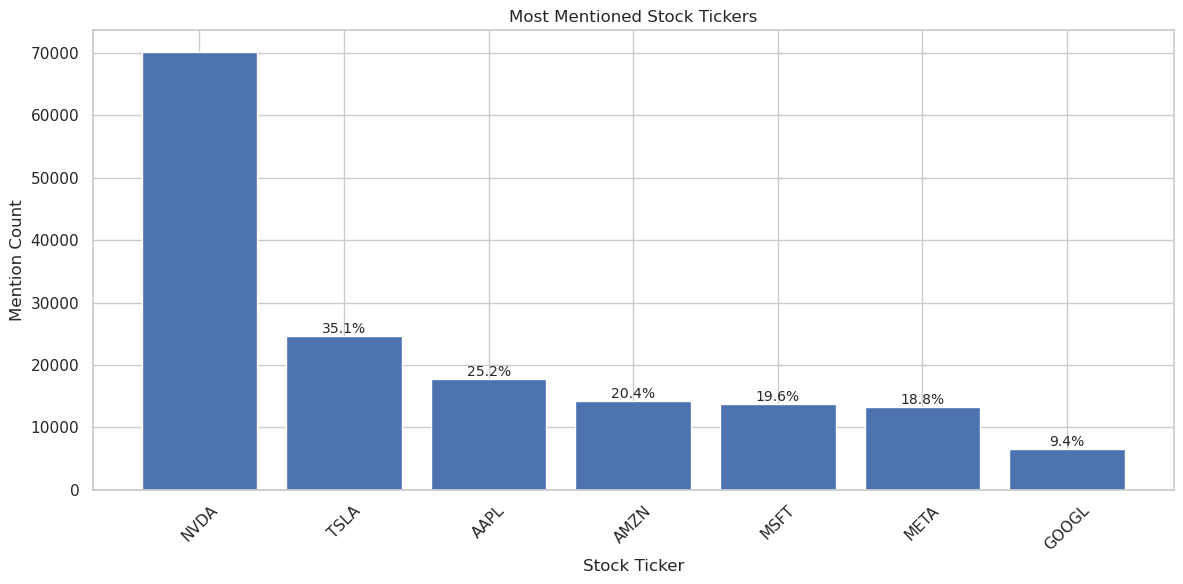

In [40]:
# 7. STOCK TICKER ANALYSIS
# Check for most mentioned stocks
stocks_to_check = ["nvda", "aapl", "msft", "googl", "amzn", "meta", "tsla"]
stock_counts = []

for stock in stocks_to_check:
    stock_pattern = "\\$" + stock
    stock_count = tweet_df.filter(lower(col("full_text")).rlike(stock_pattern)).count()
    stock_counts.append((stock.upper(), stock_count))

import pandas as pd
import matplotlib.pyplot as plt

stock_df = pd.DataFrame(stock_counts, columns=["Ticker", "Count"])
stock_df = stock_df.sort_values("Count", ascending=False)

# Get NVDA count for percentage reference
nvda_count = stock_df.loc[stock_df["Ticker"] == "NVDA", "Count"].values[0]

plt.figure(figsize=(12, 6))
bars = plt.bar(stock_df["Ticker"], stock_df["Count"])
plt.title("Most Mentioned Stock Tickers")
plt.xlabel("Stock Ticker")
plt.ylabel("Mention Count")
plt.xticks(rotation=45)

# Annotate bars with percentages relative to NVDA
for bar, count in zip(bars, stock_df["Count"]):
    if count != nvda_count:
        percentage = (count / nvda_count) * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{percentage:.1f}%", 
                 ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


StatementMeta(StockPool, 3, 50, Finished, Available, Finished)

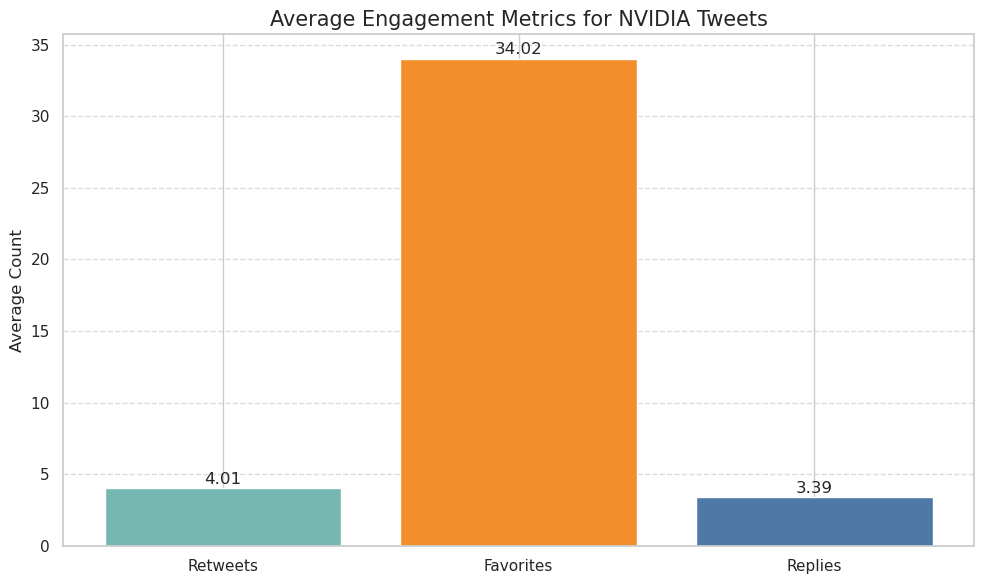

NVIDIA Tweet Analysis Results:
Number of NVIDIA tweets: 70127
Average retweets: 4.01
Average favorites: 34.02
Average replies: 3.39


In [49]:
# Extract engagement metrics for NVIDIA tweets only
nvidia_metrics = nvidia_stats.toPandas()

# Reshape the data for better visualization
nvidia_engagement = pd.DataFrame({
    'Metric': ['Retweets', 'Favorites', 'Replies'],
    'Value': [
        float(nvidia_stats.select("avg_retweets").collect()[0][0]),
        float(nvidia_stats.select("avg_favorites").collect()[0][0]),
        float(nvidia_stats.select("avg_replies").collect()[0][0])
    ]
})

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(nvidia_engagement['Metric'], nvidia_engagement['Value'], color=['#76b7b2', '#f28e2c', '#4e79a7'])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

plt.title('Average Engagement Metrics for NVIDIA Tweets', fontsize=15)
plt.ylabel('Average Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Also display the raw numbers
print(f"NVIDIA Tweet Analysis Results:")
print(f"Number of NVIDIA tweets: {nvidia_stats.select('nvda_tweet_count').collect()[0][0]}")
print(f"Average retweets: {nvidia_stats.select('avg_retweets').collect()[0][0]:.2f}")
print(f"Average favorites: {nvidia_stats.select('avg_favorites').collect()[0][0]:.2f}")
print(f"Average replies: {nvidia_stats.select('avg_replies').collect()[0][0]:.2f}")